## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path_img = Path('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest')

## Data

In [4]:
fnames = get_image_files(path_img/'train/6-20-FLIR/Images')
fnames[:3]

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Images/DJI_0440.jpg'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Images/DJI_0036.jpg'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Images/DJI_0168.jpg')]

In [5]:
lbl_names = get_image_files(path_img/'train/6-20-FLIR/Pixel Labeled/CPanel_HotSpot_Unsure_Rest/')
lbl_names[:3]

[PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Pixel Labeled/CPanel_HotSpot_Unsure_Rest/DJI_0053.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Pixel Labeled/CPanel_HotSpot_Unsure_Rest/DJI_0488.png'),
 PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Pixel Labeled/CPanel_HotSpot_Unsure_Rest/DJI_0261.png')]

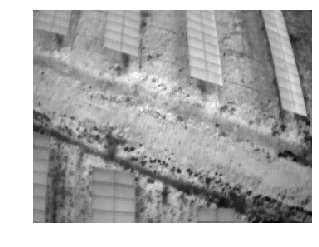

In [6]:
img_f = fnames[678]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
img_f.parent.parent/'Pixel Labeled/CPanel_HotSpot_Unsure_Rest'/f'{img_f.stem}.png'

PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/CPanel_HotSpot_Unsure_Rest/train/6-20-FLIR/Pixel Labeled/CPanel_HotSpot_Unsure_Rest/DJI_0125.png')

In [8]:
get_y_fn = lambda x: x.parent.parent/'Pixel Labeled/CPanel_HotSpot_Unsure_Rest'/f'{x.stem}.png'

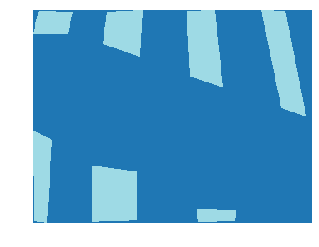

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 336]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 1, 1,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
# codes = np.loadtxt(path/'codes.txt', dtype=str); codes

## Datasets

In [11]:
src_size

array([256, 336])

In [12]:
size = 256, 256#//2
bs=6
size

(256, 256)

In [13]:
src = (SegmentationItemList.from_folder(path_img, recurse=True, extensions='.jpg')
        .split_by_folder('train','val')
        .label_from_func(get_y_fn, classes=['unsure', 'panel','hs','rest']))

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

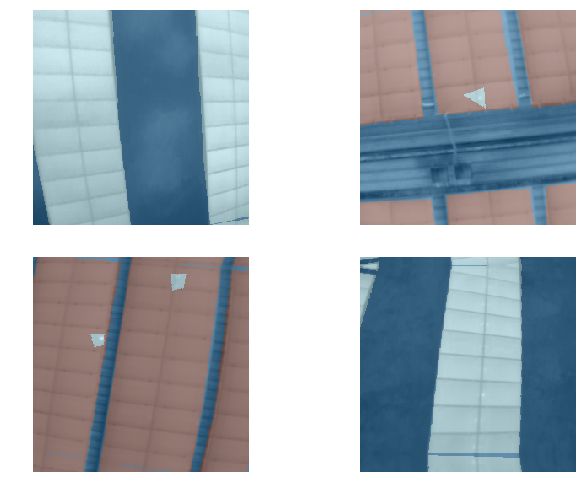

In [15]:
data.show_batch(2, figsize=(10,7))

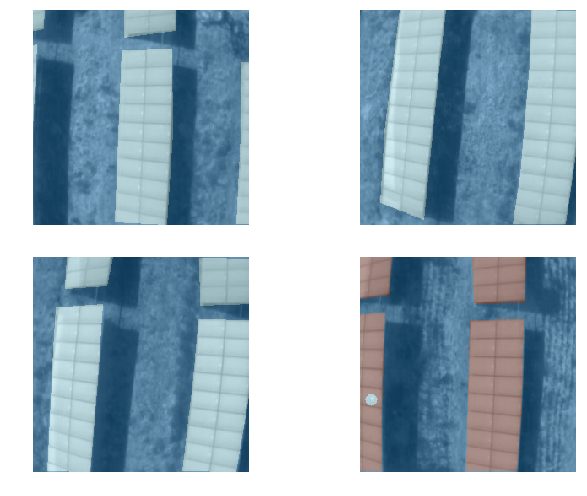

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
data.train_ds[0]

(Image (3, 256, 256), ImageSegment (1, 256, 256))

## Model

In [18]:
# name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != 7
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_camvid
# metrics=accuracy

In [20]:
learn = Learner.create_unet(data, models.resnet34, metrics=acc_camvid)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


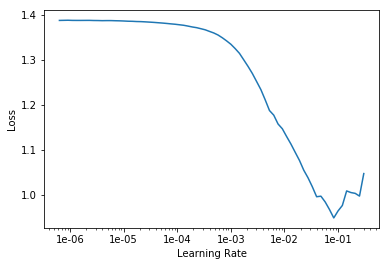

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=1e-3

In [23]:
learn.fit_one_cycle(10, slice(lr))

Total time: 02:33
epoch  train_loss  valid_loss  acc_camvid
1      0.394362    0.176009    0.971542    (00:16)
2      0.156705    0.115933    0.961709    (00:15)
3      0.114227    0.091700    0.970766    (00:15)
4      0.104954    0.082843    0.974459    (00:15)
5      0.103012    0.090087    0.972706    (00:15)
6      0.090843    0.080370    0.974171    (00:15)
7      0.089219    0.090838    0.972741    (00:15)
8      0.076892    0.071110    0.977411    (00:15)
9      0.078341    0.078515    0.975587    (00:15)
10     0.075437    0.079296    0.975118    (00:15)



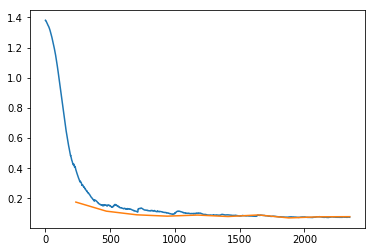

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

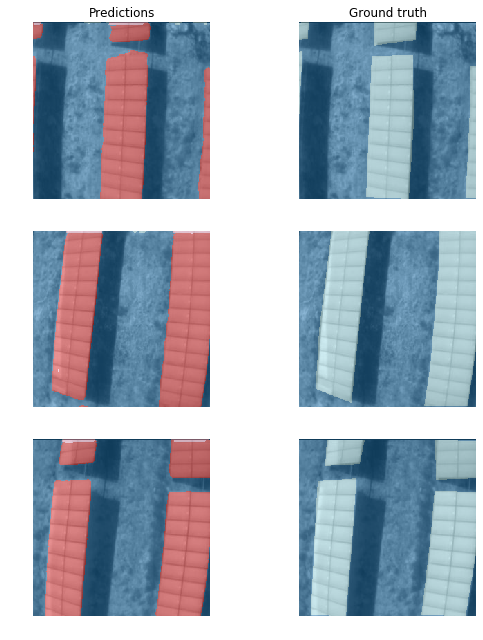

In [27]:
learn.show_results()

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


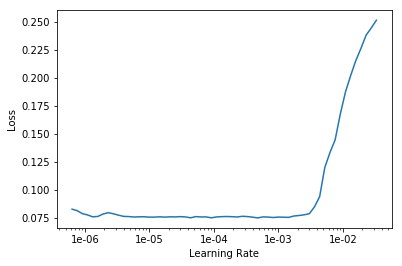

In [29]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lrs = slice(1e-5,lr/5)

In [32]:
learn.fit_one_cycle(12, lrs)

Total time: 03:44
epoch  train_loss  valid_loss  acc_camvid
1      0.075110    0.081676    0.973944    (00:18)
2      0.074359    0.074867    0.976497    (00:18)
3      0.076963    0.077730    0.975865    (00:18)
4      0.076993    0.073064    0.975842    (00:18)
5      0.073710    0.074791    0.975356    (00:18)
6      0.071913    0.070515    0.977263    (00:18)
7      0.074013    0.075267    0.975350    (00:18)
8      0.072305    0.075782    0.975737    (00:18)
9      0.069268    0.076581    0.975610    (00:18)
10     0.070596    0.076854    0.975473    (00:18)
11     0.070860    0.074694    0.975650    (00:18)
12     0.068313    0.075734    0.975617    (00:18)



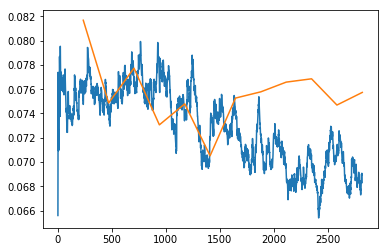

In [34]:
learn.recorder.plot_losses()

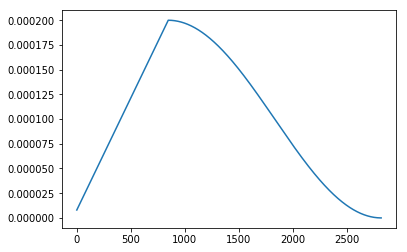

In [35]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

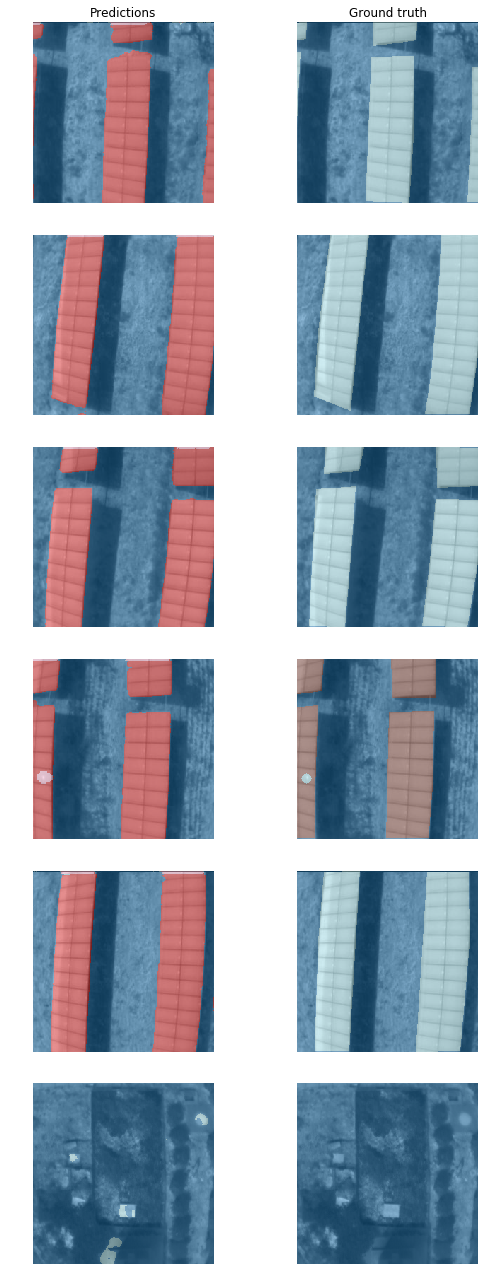

In [44]:
learn.show_results(rows=6)

In [59]:
learn.show_results?

In [117]:
ds_type = DatasetType.Valid
ds1 = learn.dl(ds_type).dataset
preds1 = learn.pred_batch()
xys1 = [ds1[i] for i in range(9)]
# xys1[0][0].show_results(xys, preds, **kwargs)

In [118]:
len(xys1);
preds1.shape

9

torch.Size([9, 4, 256, 256])

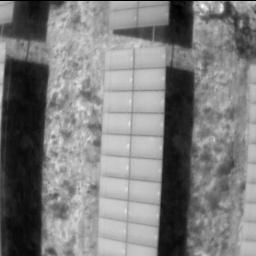

In [119]:
xys1[0][0]

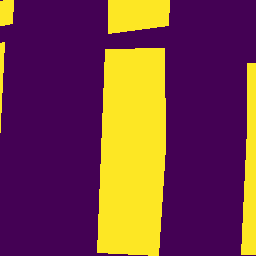

In [120]:
xys1[0][1]

In [ ]:
def show_results(self, xys, preds, figsize:Tuple[int,int]=None):
        rows = len(xys)
        figsize = ifnone(figsize, (8,3*rows))
        _,axs = plt.subplots(rows, 2, figsize=figsize)
        axs[0,0].set_title('Predictions')
        axs[0,1].set_title('Ground truth')
        for i,(x,y) in enumerate(xys):
            x.show(ax=axs[i,1], y=y)
            pred = y.reconstruct_output(preds[i], x)
            x.show(ax=axs[i,0], y=pred)
        plt.tight_layout()

In [168]:
i=8

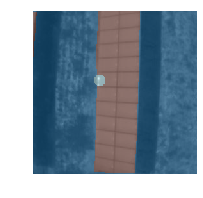

In [169]:
xys1[i][0].show(y=xys1[i][1])

In [170]:
pred1=xys1[i][1].reconstruct_output(preds1[i], xys1[i][0])

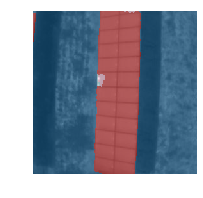

In [171]:
xys1[i][0].show(y=pred1)

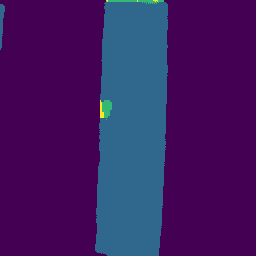

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

array([0, 1, 2, 3])

In [172]:
pred1;
image2np(pred1.data);
np.unique(image2np(pred1.data))

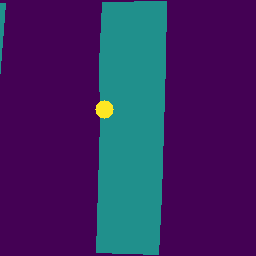

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [1, 1, 1, 1, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

array([0, 1, 2])

In [173]:
xys1[i][1];
image2np(xys1[i][1].data);
np.unique(image2np(xys1[i][1].data))

In [174]:
(image2np(pred1.data) == image2np(xys1[i][1].data)).sum()/(256*256)

0.9832916259765625

In [106]:
image2np(pred1.data).shape

(256, 256)

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


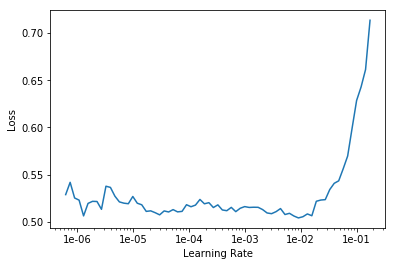

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

Total time: 08:44
epoch  train_loss  valid_loss  acc_camvid
1      0.454597    0.349557    0.900428    (01:02)
2      0.418897    0.351502    0.897495    (00:51)
3      0.402104    0.330255    0.906775    (00:50)
4      0.385497    0.313330    0.911832    (00:51)
5      0.359252    0.297264    0.916108    (00:52)
6      0.335910    0.297875    0.917553    (00:50)
7      0.336133    0.305602    0.913439    (00:51)
8      0.321016    0.305374    0.914063    (00:51)
9      0.311554    0.299226    0.915997    (00:51)
10     0.308389    0.301060    0.915253    (00:51)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

Total time: 09:30
epoch  train_loss  valid_loss  acc_camvid
1      0.323283    0.300749    0.915948    (00:56)
2      0.329482    0.290447    0.918337    (00:56)
3      0.324378    0.298494    0.920271    (00:57)
4      0.316414    0.296469    0.918053    (00:56)
5      0.305226    0.284694    0.920893    (00:57)
6      0.301774    0.306676    0.914202    (00:57)
7      0.279722    0.285487    0.919991    (00:57)
8      0.269306    0.285219    0.920963    (00:57)
9      0.260325    0.284758    0.922026    (00:57)
10     0.251017    0.285375    0.921562    (00:57)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

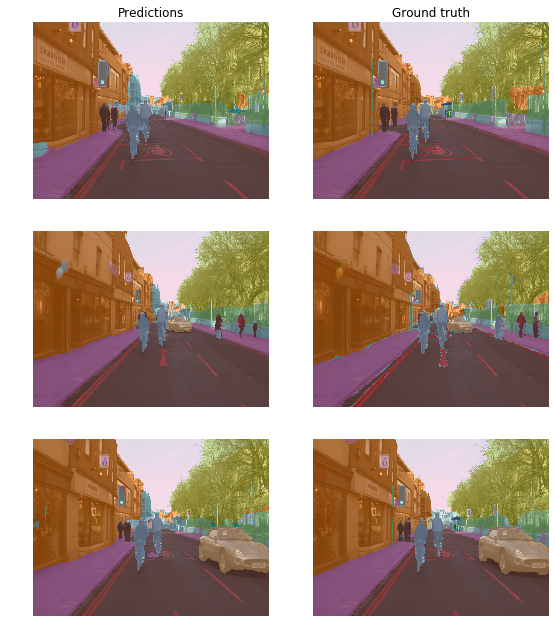

In [ ]:
learn.show_results()